# **MWE of community assembly**

## **Context**

1. **Project background**：
This project is part of a big new program titled ‘A new Green Revolution: Manipulating the soil microbiome to enhance the sustainability of 21st century agriculture,’. The current focus is to optimise/engineer soil microbiomes to suppress the fungus Gaeumannomyces tritici, which causes the **take-all disease** in wheat (T. aestivum).

2. **Microbial community coalescence**：
It is the process by which two distinct microbial communities encounter one another and interact to form a new ‘daughter’ community. This assemblage may more closely resemble one ‘parent’ community than the other, and its functional profile may be totally unique. We plan to use a coalescence method to ensure resistant community is intact in order to carry out its desired function in soil.


## **Obectives**

**Can we predict winners and losers during coalescence?**

This very basic question remains relatively un-explored. However, we did have some insights on community assembly. That is, species with higher CUE value tend to survive. And there is certain connection between species richness and CUE variance.

We will use the similiar methdology as community assembly to simulate the community dynamics during coalescence, mediated by temperature. By doing that, we hope to predict the result of community coalescence through carbon usage efficiency appearance of species in different temperature. The outcome of this research will give some foundamental information for the coalescence experiments and the dealing with take-all disease project.

**Microbial Consumer Resource Model**

$$
\frac{dC_i}{dt} = \sum_{\alpha=0}^{M} C_i R_{\alpha} u_{i\alpha} (1 - \lambda_{\alpha}) - C_i m_i
$$

$$
\frac{dR_{\alpha}}{dt} = \rho_{\alpha} - R_{\alpha} \omega_{\alpha} - \sum_{i=0}^{N} C_i R_{\alpha} u_{i\alpha} + \sum_{i=0}^{N} \sum_{\beta=0}^{M} C_i R_{\beta} u_{i\beta} l_{i\beta\alpha}
$$


| **Parameter** | **Description** | **Key** |
|--------------|---------------|--------|
| $C_i$ | Biomass of the $i$th consumer | - |
| $R_{\alpha}$ | Mass of the $\alpha$th resource | - |
| $N$ | Number of consumer populations | $N$ |
| $M$ | Number of resources | $M$ |
| $u_{i\alpha}$ | Uptake rate of the $\alpha$th resource by the $i$th consumer | $u$ |
| $m_i$ | Loss term for the $i$th consumer | $m$ |
| $\rho_{\alpha}$ | Inflow rate for the $\alpha$th resource | $\rho$ |
| $\omega_{\alpha}$ | Outflow term for the $j$th resource | $\omega$ |
| $l_{i\alpha\beta}$ | Proportion of uptake of the $\alpha$th resource leaked to the $\beta$th resource by $i$th consumer | $l$ |
| $\lambda_{\alpha}$ | Total proportion of the $\alpha$th resource leaked, same as $\sum_{\beta} l_{\alpha\beta}$ | $\lambda$ |


We adapt this model because it is able to capture the complex interactions of both competition for resources and the exchange of metabolic by-products.

## **Simulation:**

Import the packages

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import os

In [16]:
sys.path.append(os.path.expanduser("~/Documents/MiCRM/code"))
import param_3D

`MiCRM` is the package for simulation of Microbial Consumer Resource (MiCRM) systems. It countains some aggregated functions.

Now we  *set system size and leakage rate*

In [17]:
# Parameters
N = 20 # Number of consumers
M = 12 # Number of resources
λ = 0.3  # Total leakage rate

N is the **number of species in a community**, M is the **number of resource types**, leakage is the overall leakage rate

Next, *make uptake matrix out of dirichlet distribution*

In [18]:
# Each consumer's uptake scaling factor
λ_u = np.random.uniform(0.8, 1, N)  
σ = np.random.uniform(0.05 * λ_u, 0.2 * λ_u)
N_modules = 5  # Number of modules connecting consumers to resources
s_ratio = 4.0  # Strength of modularity

In [19]:
# Generate uptake matrix, defining consumer-resource interaction strengths
u = param_3D.modular_uptake(N, M, N_modules, s_ratio, λ_u, σ)  

The N_modules determines how many different blocks of resources will be divided into, and s_ratio determines how much will species focus on inner group resources. *More details about this function see document of functions

*Define other terms*

In [20]:
# Mortality rate for each consumer
m = np.full(N, 0.2)  
# Input rate of each resource
rho = np.full(M, 1)  
# Decay rate for each resource
omega = np.full(M, 0.01)  

m is a loss term for the the consumers. It can be simply understood as the proportion of deceased organisms.

ρ is the resource inflow amount of the system and ω is outflow rate.

Next, we *make leakage matrix out of dirichlet distribution and make it modular*

In [21]:
# Total leakage rate for each resource
lambda_alpha = np.full(M, λ)
# Generate leakage tensor representing leakage flow between consumers and resources
l = param_3D.generate_l_tensor(N, M, N_modules, s_ratio, λ)  

We make it N times to generate a unique resource leakage matrix for each consumer. Similarly to the `MiCRM.Parameters.modular_uptake`, the N_modules determines how many the different blocks of resources will be divided into, and s_ratio determines the structure of leakage.

For now, we finished the parameter part and it is time to create an **Ordinary Differential Equation Problem** object which defines the problem for the ODE solver and then solve it with the aptly solve function.
To define the ODEProblem we need to specify the initial state of the system as well as the timespan

In [22]:
# ODE system describing the dynamics of consumers (C) and resources (R)
def dCdt_Rdt(t, y):
    C = y[:N]  # Consumer populations
    R = y[N:]  # Resource concentrations
    dCdt = np.zeros(N)
    dRdt = np.zeros(M)
    
    # Consumer growth equation
    for i in range(N):
        dCdt[i] = sum(C[i] * R[alpha] * u[i, alpha] * (1 - lambda_alpha[alpha]) for alpha in range(M)) - C[i] * m[i]
    
    # Resource depletion and leakage equation
    for alpha in range(M):
        dRdt[alpha] = rho[alpha] - R[alpha] * omega[alpha]  # Input and decay
        dRdt[alpha] -= sum(C[i] * R[alpha] * u[i, alpha] for i in range(N))  # Uptake by consumers
        dRdt[alpha] += sum(sum(C[i] * R[beta] * u[i, beta] * l[i, beta, alpha] for beta in range(M)) for i in range(N))  # Leakage contributions
    
    return np.concatenate([dCdt, dRdt])
    
# Initial conditions: assume all consumers and resources start at concentration 1
C0 = np.full(N, 0.1)
R0 = np.full(M, 1)
Y0 = np.concatenate([C0, R0])
    
t_span = (0, 700)
t_eval = np.linspace(*t_span, 300)
sol = solve_ivp(dCdt_Rdt, t_span, Y0, t_eval=t_eval)

x0 is an initial state, a one-dimensional array (vector) of length N+M, where all elements are initialized to 1.  

The initial time is 0.0 and the final time is 700

At last, we *visualize the dynamics of system* 

## **Visualization**

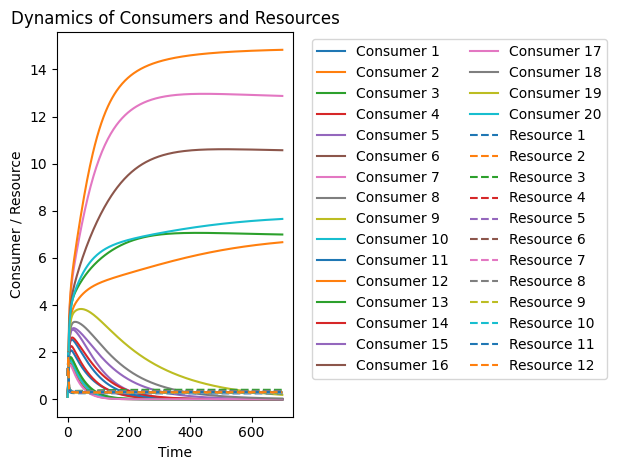

In [23]:
# Visualize system dynamics
for i in range(N):
    plt.plot(sol.t, sol.y[i], label=f'Consumer {i+1}')
for alpha in range(M):
    plt.plot(sol.t, sol.y[N + alpha], label=f'Resource {alpha+1}', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Consumer / Resource')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=2, fontsize=10, columnspacing=1.5)
plt.title('Dynamics of Consumers and Resources')
plt.tight_layout()
plt.savefig("results/dynamics_of_consumers_resources.png", dpi=300, bbox_inches='tight')
plt.show()
   

Figure 1: Dynamics of consumers and resources. It displays how population of species and amount of resources change in a system

## **Calculation of carbon usage efficiency**

Carbon Use Efficiency (CUE) is a key ecological functional metric that describes the proportion of assimilated carbon allocated to biomass growth compared with total carbon uptake. It is commonly used in microbial ecology and soil carbon cycling to understand how organisms utilize carbon resources.

Usually it is defined as the ratio of growth (μ) to assimilation, that is, CUE = μ/(μ + R), where R includes any Carbon losses to respiration. However, depending on the research focus, the definition of CUE may vary across different contexts.

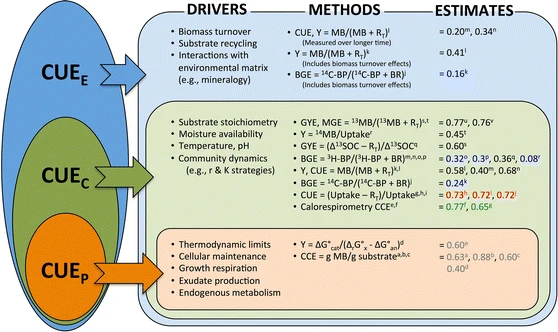

Estimates are color coded by the type of sample analyzed: soil (black), water (blue), isotopologues in soil (red), calorespirometry in soil (green) and culture-based/thermodynamics (grey). CUEP examples depict glucose (or similar) amendment. CUE carbon use efficiency, Y yield, MB microbial biomass, R respiration, BGE bacterial growth efficiency, BP bacterial production, BR bacterial respiration, MGE microbial growth efficiency, SOC soil organic carbon, CCE carbon conversion efficiency, ΔG°cat, Gibbs energy of catabolism; ΔrG°x, Gibbs energy of growth; ΔG°an, Gibbs energy of anabolism. aLinton and Stephenson (1978), bGommers et al. (1988), cBabel (2009), dTannler et al.

https://link.springer.com/article/10.1007/s10533-016-0191-y

### **Species level CUE:**


Species’ carbon use efficiency (CUE, henceforth denoted by ε) reflects the resource utilisation ability of a species. It is  usually quantified as the partitioning of harvested resources into cell growth versus carbon loss mainly through  leakage and maintenance

$$
\varepsilon_j = \frac{\sum_{\alpha=1}^{M} u_{i\alpha}(T) \hat{R}_{\alpha} \left( 1 - l_{\alpha}^{j} \right) - m_{i}(T)}
{\sum_{\alpha=1}^{M} u_{i\alpha}(T) \hat{R}_{\alpha}}
$$

$$
\begin{array}{|c|c|}
\hline
\textbf{Symbol} & \textbf{Meaning} \\
\hline
u_{i\alpha}(T) & \text{Uptake coefficient} \\
\hat{R}_{\alpha} & \text{Resource availability} \\
l_{\alpha}^{j} & \text{Leakage fraction} \\
m_{i}(T) & \text{Maintenance cost} \\
M & \text{Total number of resources} \\
\hline
\end{array}
$$




In [27]:
# CUE
CUE = np.zeros(N)
total_uptake = np.sum(u * R0, axis=1)  # (N × M) @ (M,) -> (N,)
net_uptake = np.sum(u * R0 *(1-lambda_alpha), axis=1)-m # Adjusted for leakage and metabolism
CUE = net_uptake/total_uptake
print(f"Carbon Use Efficiency (CUE): {CUE.tolist()}")

Carbon Use Efficiency (CUE): [0.4672261763676292, 0.4873916829442896, 0.49843511476800356, 0.47560456032025156, 0.4818867641858455, 0.45033274097014375, 0.49717057820859095, 0.4621138884600839, 0.45477029814354103, 0.4546197670841525, 0.4751801915415033, 0.4989623042233536, 0.4572229730846483, 0.47565333479229094, 0.47952871756640303, 0.492735123920691, 0.4514413049844413, 0.48245139297331674, 0.48662276909234664, 0.4917201186631484]


### **Community level CUE:**

**Experimental measurement**

In labs, the meaning of CUE is usually defined as the fraction of consumed carbon that is converted into new microbial biomass.

Some researchers(https://journals.asm.org/doi/10.1128/aem.01851-20) quantifiedhow much carbon had been assimilated into biomass versus how much was depleted from the medium. This was accomplished by measuring total carbon in the culture vs. carbon remaining in solution after removing cells.
The numerator is biomass, obtained by subtracting the carbon weight of the residual medium from the total carbon weight in the culture plate. The denominator is the amount of resource consumption from the previous time point to the current time point.


$$
\text{CUE} = \frac{C_{\text{unfiltered}}(t) - C_{\text{filtered}}(t)}{C_{\text{unfiltered}}(t-1) - C_{\text{unfiltered}}(t)}
$$

- $\displaystyle C_{\text{unfiltered}}(t)$ → Total carbon in the culture (cells + dissolved organic carbon) at time $t$.
- $\displaystyle C_{\text{filtered}}(t)$ → Carbon remaining in the medium after filtering out cells at time $t$.
- $\displaystyle C_{\text{unfiltered}}(t-1)$ → Total carbon in the previous time step $t-1$.


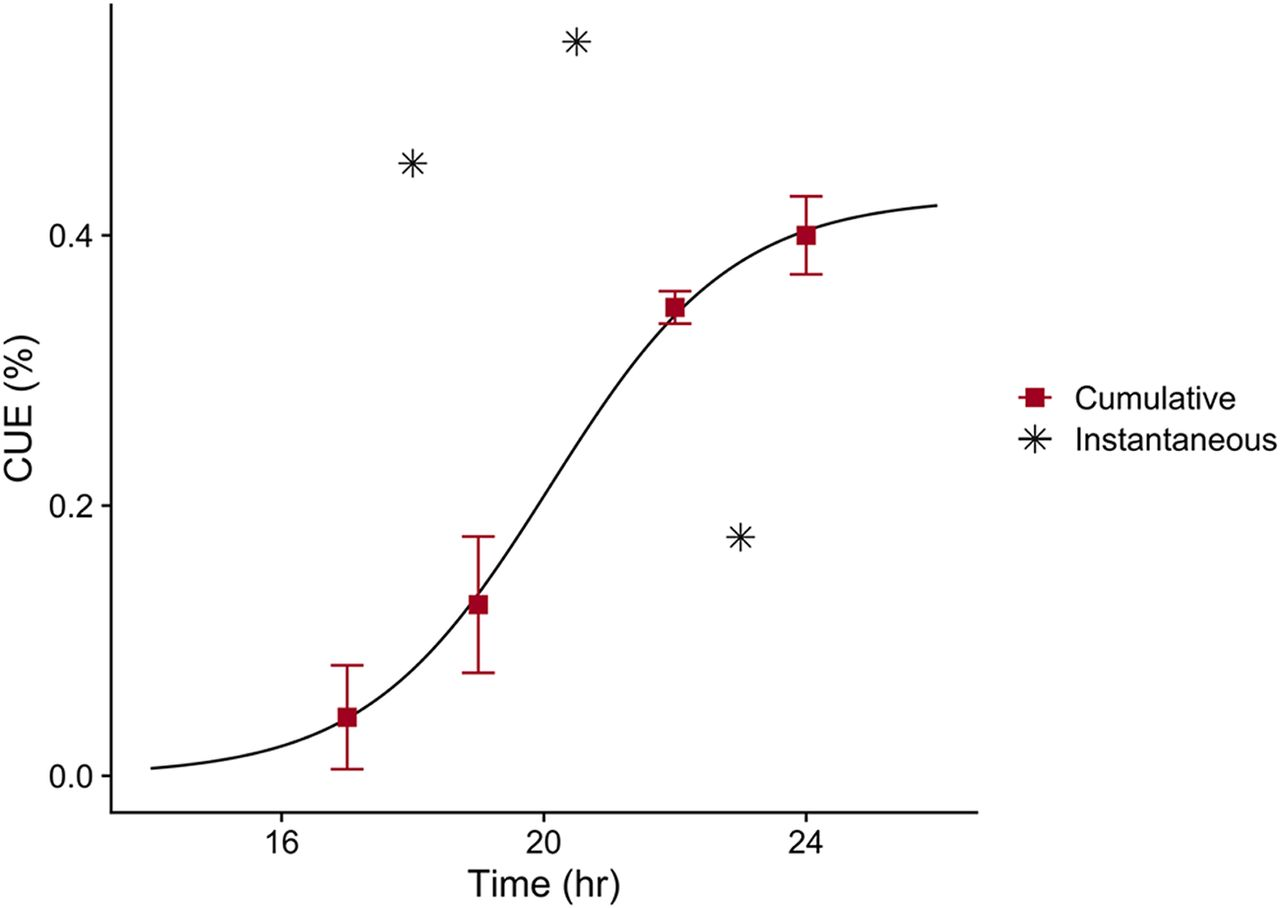

Carbon use efficiency (CUE) during microbial growth of Paraburkholderia sp. 1N on SESOM. All points represent means with standard error bars (n = 3). Instantaneous CUE was calculated from growth in between biomass sampling points, so estimated values are displayed at the center of the measurement period. A similar 4-point sigmoidal curve was fit for cumulative CUE

Some others use the very original defination:
$$
CUE = \frac{\text{Growth Rate}}{\text{Growth Rate} + \text{Respiration Rate}}
$$

where the amount of CO2 -C produced during the incubation period was recorded as soil respiration flux. Isotope 18O was used for the measurement of DNA change and eventually growth rate

- The increase in DNA (\(\Delta DNA\)) was calculated as:

$$
\Delta DNA = 0.33 \times \frac{\text{at\%}^{18}O_{DNA_{labeled}} - \text{at\%}^{18}O_{DNA_{natural}}}{\text{at\%}^{18}O_{water} - \text{at\%}^{18}O_{DNA_{natural}}}
$$

- **DNA increment (\(\Delta DNA\))** was converted to **microbial biomass carbon (\(\Delta MBC\))** using a linear regression model:
$$
\Delta MBC = \beta \times \Delta DNA
$$

- The final **growth rate** was calculated as:
$$
\text{Growth Rate} = \frac{\Delta MBC}{t}
$$
where \( t \) is the incubation time (24 h).

**Simulation calculation**

The cumulative Carbon Use Efficiency (CUE) is calculated based on changes between current time points and initial state using the following formula:

$$
CUE = \frac{C_t - C_0}{R_0 - R_t + \text{inflow} \times t}
$$

where:
- $\displaystyle C_t$ is the carbon at time $t$,
- $\displaystyle C_0$ is the initial carbon,
- $\displaystyle R_t$ is the resource at time $t$,
- $\displaystyle R_0$ is the initial resource,
- $\displaystyle \text{inflow}$ is the resource inflow rate,
- $\displaystyle t$ is the elapsed time.

This formula captures the efficiency of carbon utilization over time.